In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import time
import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# Replace with your actual dataset path
data_df = pd.read_json("C:/Users/nihal/Downloads/archive (1)/Sarcasm_Headlines_Dataset.json", lines=True)

# Ensure labels are integers
data_df["is_sarcastic"] = data_df["is_sarcastic"].astype(int)
print("Dataset shape:", data_df.shape)
print(data_df.head())

Dataset shape: (26709, 3)
                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(data_df["headline"]),
    np.array(data_df["is_sarcastic"]),
    test_size=0.3,
    random_state=42,
    stratify=data_df["is_sarcastic"]   # ✅ preserve class balance
)

X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 18696, Val: 4006, Test: 4007


In [4]:
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

max_len = 64  # shorter = faster, headlines are short

train_encodings = tokenizer(list(X_train), truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
val_encodings   = tokenizer(list(X_val),   truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
test_encodings  = tokenizer(list(X_test),  truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")

In [5]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

train_dataset = TextDataset(train_encodings, y_train)
val_dataset   = TextDataset(val_encodings, y_val)
test_dataset  = TextDataset(test_encodings, y_test)

In [6]:
BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [7]:
class SarcasmClassifier(nn.Module):
    def __init__(self, model_name, dropout=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]  # CLS token
        x = self.dropout(pooled)
        x = self.fc(x)  # logits
        return x

model = SarcasmClassifier(MODEL_NAME).to(device)

In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=2e-5)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

In [9]:
scaler = torch.amp.GradScaler("cuda")   # ✅ new API

EPOCHS = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

save_path = "best_model.pt"

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # --- Training ---
    model.train()
    total_loss_train, total_acc_train = 0, 0
    loop = tqdm(train_dataloader, desc="Training", leave=True)

    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        with torch.amp.autocast("cuda"):
            outputs = model(input_ids, attention_mask).squeeze(1)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss_train += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        total_acc_train += (preds == labels).sum().item()

        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss_train / len(train_dataloader)
    avg_train_acc = total_acc_train / len(train_dataset)

    # --- Validation ---
    model.eval()
    total_loss_val, total_acc_val = 0, 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            with torch.amp.autocast("cuda"):
                outputs = model(input_ids, attention_mask).squeeze(1)
                loss = criterion(outputs, labels)

            total_loss_val += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            total_acc_val += (preds == labels).sum().item()

    avg_val_loss = total_loss_val / len(val_dataloader)
    avg_val_acc = total_acc_val / len(val_dataset)

    scheduler.step(avg_val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(avg_train_acc)
    val_accs.append(avg_val_acc)

    print(f"Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}")



Epoch 1/10


Training: 100%|██████████| 1169/1169 [01:13<00:00, 15.96it/s, loss=0.0184]


Train Loss: 0.2735, Acc: 0.8824 | Val Loss: 0.2035, Acc: 0.9136

Epoch 2/10


Training: 100%|██████████| 1169/1169 [00:54<00:00, 21.36it/s, loss=0.0241] 


Train Loss: 0.1182, Acc: 0.9568 | Val Loss: 0.1949, Acc: 0.9216

Epoch 3/10


Training: 100%|██████████| 1169/1169 [00:54<00:00, 21.33it/s, loss=0.0862]  


Train Loss: 0.0434, Acc: 0.9860 | Val Loss: 0.2465, Acc: 0.9174

Epoch 4/10


Training: 100%|██████████| 1169/1169 [00:55<00:00, 21.22it/s, loss=0.000805]


Train Loss: 0.0266, Acc: 0.9915 | Val Loss: 0.3238, Acc: 0.9196

Epoch 5/10


Training: 100%|██████████| 1169/1169 [00:54<00:00, 21.46it/s, loss=0.0035]  


Train Loss: 0.0171, Acc: 0.9949 | Val Loss: 0.4574, Acc: 0.8904

Epoch 6/10


Training: 100%|██████████| 1169/1169 [00:54<00:00, 21.49it/s, loss=0.000842]


Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.3919, Acc: 0.9136

Epoch 7/10


Training: 100%|██████████| 1169/1169 [00:54<00:00, 21.39it/s, loss=0.000743]


Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.3779, Acc: 0.9214

Epoch 8/10


Training: 100%|██████████| 1169/1169 [00:58<00:00, 20.14it/s, loss=0.0024]  


Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.3341, Acc: 0.9289

Epoch 9/10


Training: 100%|██████████| 1169/1169 [01:20<00:00, 14.61it/s, loss=0.00221] 


Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.3601, Acc: 0.9306

Epoch 10/10


Training: 100%|██████████| 1169/1169 [00:58<00:00, 20.04it/s, loss=0.000192]


Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.3946, Acc: 0.9294


In [11]:
model.eval()
total_loss_test, total_acc_test = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    loop = tqdm(test_dataloader, desc="Testing", leave=True)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.amp.autocast("cuda"):
            outputs = model(input_ids, attention_mask).squeeze(1)
            loss = criterion(outputs, labels)

        total_loss_test += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        total_acc_test += (preds == labels).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = total_loss_test / len(test_dataloader)
avg_test_acc = total_acc_test / len(test_dataset)

print(f"\nTest Loss: {avg_test_loss:.4f} | Test Accuracy: {avg_test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

Testing: 100%|██████████| 251/251 [00:02<00:00, 110.30it/s]


Test Loss: 0.4178 | Test Accuracy: 0.9264

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93      2248
         1.0       0.92      0.91      0.92      1759

    accuracy                           0.93      4007
   macro avg       0.93      0.92      0.93      4007
weighted avg       0.93      0.93      0.93      4007



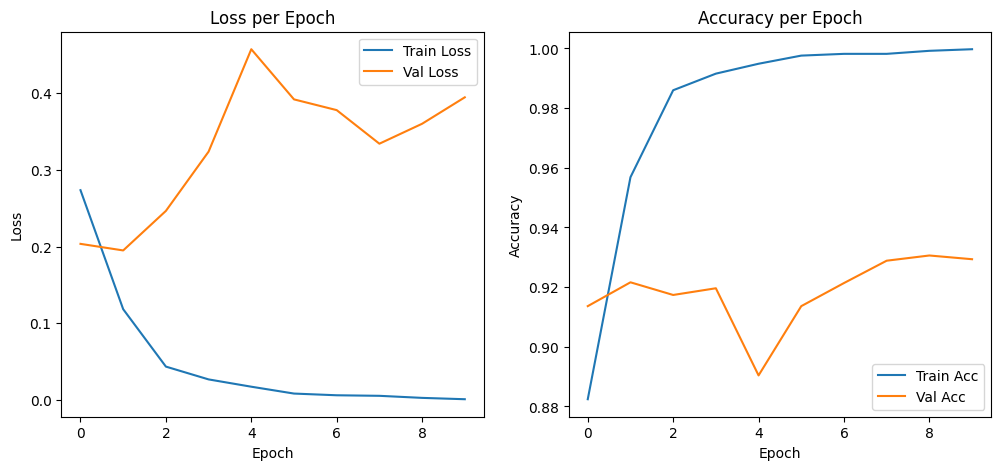

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()